# Twitter Messages Data Analysis
Code link: https://github.com/hennypurwadi/twitter_analysis

### Collect Tweets from particular geocode location in Google map
https://tinyurl.com/nh26dkkn

# 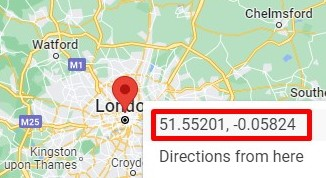

In [87]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import snscrape.modules.twitter as sntwitter
import tweepy
import unicodedata
import random
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
#!pip install wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HENNY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HENNY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Collect Tweets Without Twitter Developer Account /API: with snscrape
#pip3 install snscrape

In [2]:
#Create and append to csv file and then write tweets into csv file
tweet_data = open('London_tweets_sns.csv', 'a', newline='', encoding='utf8')
csv.writer(tweet_data).writerow(['username','tweet','hashtags']) 

#Radius around 30 km around particular geocode
max_tweets = 50
for n,tweet in enumerate(sntwitter.TwitterSearchScraper('geocode:51.55201,-0.05824,30km \
        + since:2022-07-16 until:2022-07-17 lang:en -filter:links -filter:replies').get_items()):
    
    if n > max_tweets:
        break
    csv.writer(tweet_data).writerow([tweet.user.username, tweet.content, tweet.hashtags])      
tweet_data.close()

In [3]:
df_sns = pd.read_csv('London_tweets_sns.csv')
df_sns = df_sns.dropna(subset = ['hashtags']) #Only use tweets which contained hashtags
df_sns.head()

,username,tweet,hashtags
0,BlastFMRandB,07-16-2022 19:29:01 https://t.co/qDYyfurO71 #B...,['BlastFMRandB']
3,catherineh3575,Feels like NFFC have just pulled someone in of...,['nffc']
4,HudsonFarrell,So @ConHome now finding that #KemiBadenoch is ...,"['KemiBadenoch', 'BackingBadenoch', 'KemiForPM']"
9,inb63,That's a nasty lump under Tates eye #UFCLongIs...,['UFCLongIsland']
13,LukeHugh3s,Is an escalator that goes down called a de-esc...,['thoughtsonanescalator']


### Collect Tweets With Twitter Developer Account API: with tweepy

### Twitter Developer API
We can apply for "Elevated" for free, from default "Essential" developer.

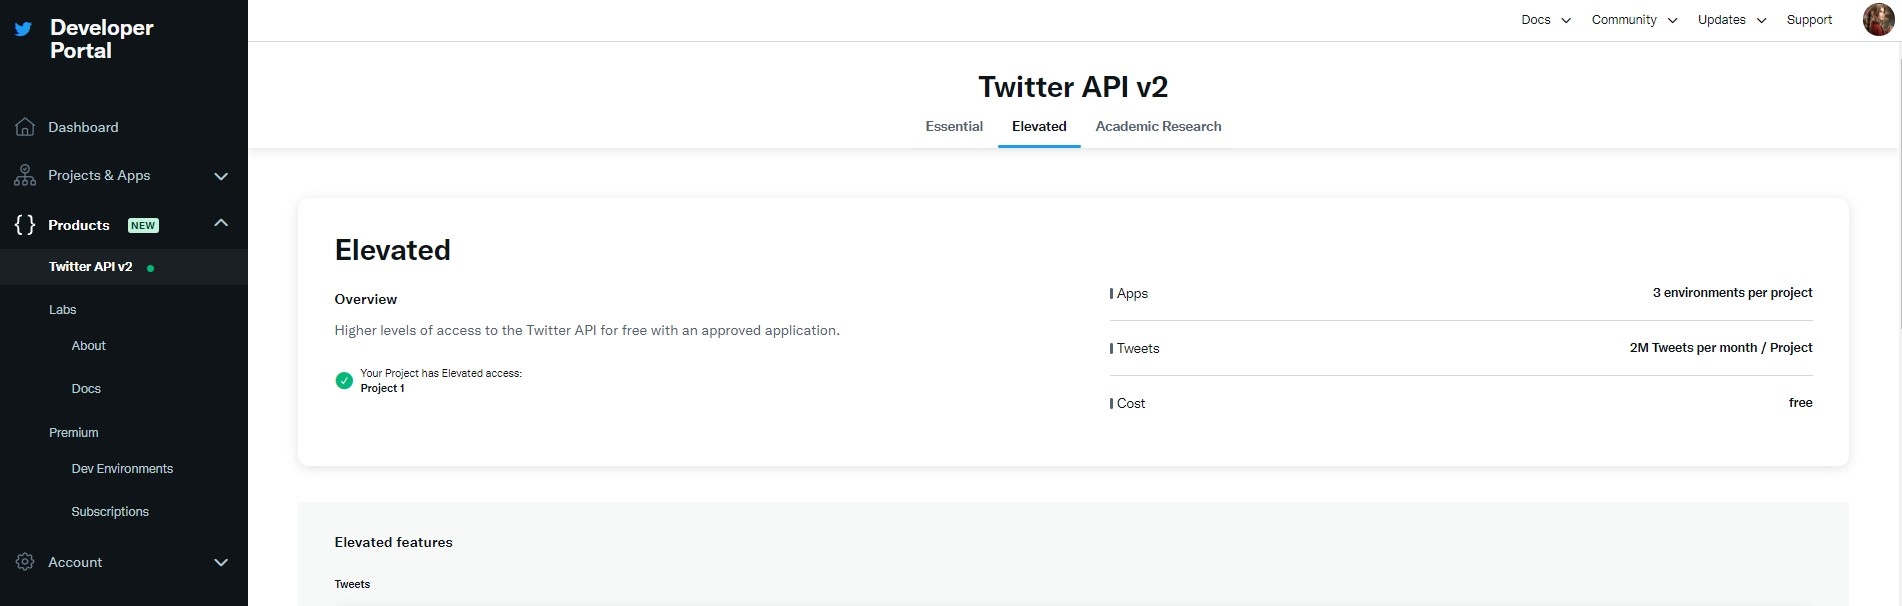

In [4]:
#https://developer.twitter.com/en/portal/dashboard

API_KEY = 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
API_SECRET = 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb'
ACCESS_TOKEN = 'cccccccccccccccccccccccccccccccccccccccccccccc'
ACCESS_TOKEN_SECRET = 'ddddddddddddddddddddddddddddddddddddddddddd'

a = tweepy.OAuthHandler(API_KEY, API_SECRET)
a.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
API = tweepy.API(a)

In [10]:
csvFile = open("london_tweets_tweepy.csv", "a+",newline="", encoding = "utf-8")
csvWriter = csv.writer(csvFile)
l = [] #location
u = [] #username
t = [] #tweet text
h = [] #hashtags

max_tweets = 100
n = 0  
for tweet in (API.search_tweets('geocode:51.55201,-0.05824,30km', lang='en',count=100, \
                    since_id="2022-07-16", until='2022-07-17')):
    #print(tweet.created_at, tweet.id, tweet.user.name,tweet.text)
    l.append(tweet.user.location)
    u.append(tweet.user.name)
    t.append(tweet.text.encode("utf-8"))
    h.append(tweet.entities['hashtags'])    
    n += 1  
    
    if n > max_tweets:
        break
          
    tweets=[tweet.created_at, tweet.id,tweet.user.location,tweet.user.name,
            tweet.text.encode("utf-8"),tweet.entities['hashtags']]
    csvWriter.writerow(tweets)

dictTweets = {"location":l,"username":u,"tweet":t, "hashtags": h}

csvFile.close()

In [11]:
df = pd.read_csv('London_tweets_tweepy.csv')
df = pd.DataFrame(dictTweets, columns=["location","username","tweet","hashtags"])
df.head()

,location,username,tweet,hashtags
0,London,some kinda Marc,"b'@Frankent95 Happy Birthday bro, whether it\x...",[]
1,"London, England",CryptoSyke,b'@StonedApeBizDAO @degenfatcats Is it 9.99 $S...,[]
2,"London, England",Air Traffic @ SE1,b'Flight: #AYY181\nReg: D-CICU\nAircraft: Bomb...,"[{'text': 'AYY181', 'indices': [8, 15]}]"
3,West Stand Upper 31 year S/T,💙Ashleymadblue ⭐️⭐️,b'Some of these bunkers are brutal #TheOpen',"[{'text': 'TheOpen', 'indices': [33, 41]}]"
4,"London, England",Hicks,b'@fuzzymittens W T ACTUAL F?????',[]


In [12]:
len(df)

100

### Remove emojis from username
Can't clean username like make Capital letter become lowercase etc, since Capital letter etc is unique part of the name.

Only remove emojis from username.

In [15]:
emoji_pattern = re.compile("["
                        "\U0001F600-\U0001F64F"  # emoticons
                        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        "\U0001F300-\U0001F5FF"  # pictographs, symbols 
                        "\U0001F700-\U0001F77F"  # alchemical symbols
                        "\U0001F680-\U0001F6FF"  # transport & map symbols
                        "\U0001FA00-\U0001FA6F"  # Chess Symbols
                        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                        "\U00002702-\U000027B0"  # Dingbats
                        "\U0001F1E0-\U0001F1FF"  # flags (iOS)   
                        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs                        
                        "\U000024C2-\U0001F251" 
                        "]+", flags=re.UNICODE)  

def delete_emoji(string):
    return emoji_pattern.sub(r'', string)

df['username_no_emoji'] = df['username'].apply(delete_emoji)
df[['username','username_no_emoji']].head(6)

,username,username_no_emoji
0,some kinda Marc,some kinda Marc
1,CryptoSyke,CryptoSyke
2,Air Traffic @ SE1,Air Traffic @ SE1
3,💙Ashleymadblue ⭐️⭐️,Ashleymadblue
4,Hicks,Hicks
5,Kyle 🌹🏳️‍🌈,Kyle ‍


## 1. Entity analysis to find 5 most active users.

In [16]:
#df['user'].unique()
userlist = df['username_no_emoji'].value_counts()
most_active_users = userlist.head(5)
most_active_users

                   2
some kinda Marc    1
ٰ                  1
Kunt Shop          1
Kate Battrick      1
Name: username_no_emoji, dtype: int64

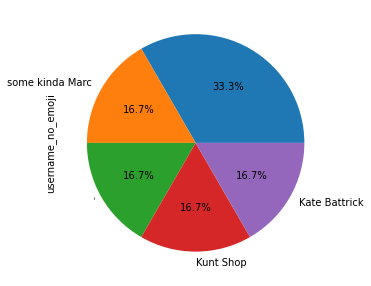

In [17]:
plot_users=most_active_users.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.rc('axes', unicode_minus=False)
plt.savefig("MostActiveUser_chart.jpeg",transparent=False, bbox_inches='tight',pad_inches=0.1)

## 2. Entity analysis to find 5 most used hastags

### Lite Cleaning for hashtags
Cleaning hashtags to get 5 most prevalent ones is lite cleaning, since each of them are unique, doesn't need to make lowercase

In [19]:
df['hashtags'].head()

0                                            []
1                                            []
2      [{'text': 'AYY181', 'indices': [8, 15]}]
3    [{'text': 'TheOpen', 'indices': [33, 41]}]
4                                            []
Name: hashtags, dtype: object

In [20]:
#Functun to convert to str
def lightclean(hashtags_data):  
    hashtags_data = str(hashtags_data) #make str
    return hashtags_data

df['Cleaned_Hashtags'] = df['hashtags'].apply(lightclean)

htag_Texts_Cleaned=df['Cleaned_Hashtags'].values
htag_Texts_Cleaned=str(htag_Texts_Cleaned)
htag_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',htag_Texts_Cleaned)
htag_Texts_Cleaned= re.sub(r' +', ' ', htag_Texts_Cleaned)
htag_Texts_Cleaned= re.sub(r' text', ' ', htag_Texts_Cleaned) #remove 'text'
print("Cleaned hashtags:" + "\n" + htag_Texts_Cleaned)

Cleaned hashtags:
  AYY indices  TheOpen indices  UFCLongIsland indices  tapinsandtapouts indices  ClosePass indices  TheHarrowInn indices  Cheam indices  CheamVillage indices  WEURO indices  BLUE indices  UFCLongIsland indices  UFCLongIsland indices  TheHitList indices 


### Counting the number of hastags

In [21]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

hashtag_count = word_count(htag_Texts_Cleaned)
print(hashtag_count)

{'AYY': 1, 'indices': 13, 'TheOpen': 1, 'UFCLongIsland': 3, 'tapinsandtapouts': 1, 'ClosePass': 1, 'TheHarrowInn': 1, 'Cheam': 1, 'CheamVillage': 1, 'WEURO': 1, 'BLUE': 1, 'TheHitList': 1}


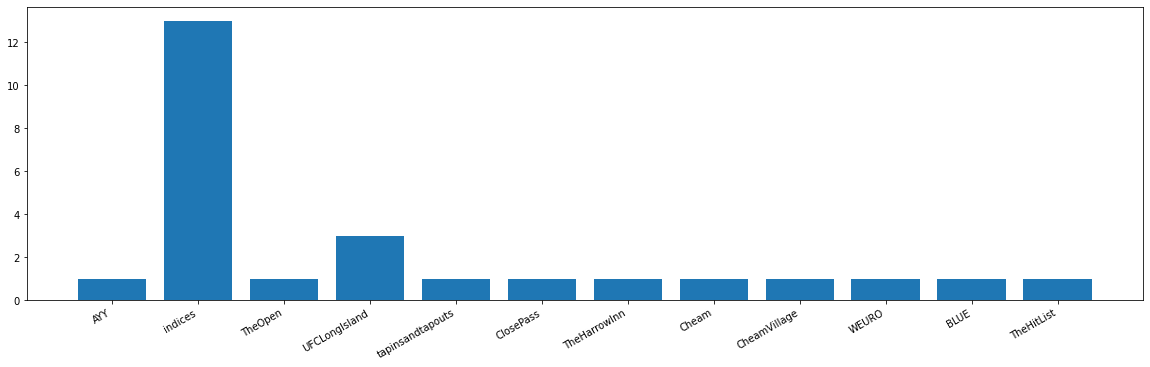

In [22]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.bar(hashtag_count.keys(), hashtag_count.values())
fig.autofmt_xdate()
plt.savefig('hashtag_count_graph.jpeg')
plt.show()

In [23]:
MostPopularHashtags = sorted(hashtag_count, key=hashtag_count.get, reverse=True)[:5]
#' '.join(MostPopularHashtags)
MostPopularHashtags

['indices', 'UFCLongIsland', 'AYY', 'TheOpen', 'tapinsandtapouts']

In [25]:
#Convert list to str

MostPopularHashtags_str = ''
i = 0
for x in MostPopularHashtags:
    i = i+1
    if i < 5:
        MostPopularHashtags_str += '#'+ x + ', '
    else:
        MostPopularHashtags_str += '#'+ x
    
print("5 Most popular hastags are : " + MostPopularHashtags_str)

5 Most popular hastags are : #indices, #UFCLongIsland, #AYY, #TheOpen, #tapinsandtapouts


## 3. Entity analysis to extract five most prevalent topics in the tweets

### Preprocessing, Cleaning with regex
Make the text lowercase, remove line breaks, punctuation, usernames, url, extra spaces, etc

In [26]:
def cleaning(tweets_data):   
    tweets_data = str(tweets_data).lower() #Make the text lowercase.
    tweets_data=re.sub(r'@\w+', ' ', tweets_data) #remove usernames
    tweets_data= re.sub(r'\b\w{1,2}\b', '', tweets_data) #remove stopwords
    #tweets_data = re.sub(r'@[A-Za-z0–9]+', '', tweets_data) #remove usernames
    tweets_data = re.sub('\n', '', tweets_data) #Remove line breaks.
    tweets_data = re.sub('[%s]' % re.escape(string.punctuation), '', tweets_data) #remove punctuation
    tweets_data = re.sub('\[.*?\]', '', tweets_data)
    tweets_data=re.sub(r'http\S+', ' ', tweets_data) #remove all Url
    tweets_data = re.sub(r'https?:\/\/.*[\r\n]*', '', tweets_data) #remove website
    tweets_data = re.sub('https?://\S+|www\.\S+', '', tweets_data)  #remove all websites 
    tweets_data = re.sub(r' +', ' ', tweets_data) #remove extra space
    tweets_data = re.sub('<.*?>+', '', tweets_data)    
    tweets_data = re.sub('\w*\d\w*', '', tweets_data)
    tweets_data = re.sub(r'^RT[\s]+', '', tweets_data)    
    tweets_data = re.sub(r'[^a-z A-Z]', ' ',tweets_data) #Remove all not characters
    tweets_data = re.sub(emoji_pattern, '', tweets_data)#remove emojis
    tweets_data = re.sub(r'#', '', tweets_data) #remove hashtags     
    return tweets_data

df['clean1_tweet'] = df['tweet'].apply(cleaning)
df_cleaned_tweets=df[['tweet','clean1_tweet']]
df_cleaned_tweets.head()

,tweet,clean1_tweet
0,"b'@Frankent95 Happy Birthday bro, whether it\x...",happy birthday bro whether happened already ...
1,b'@StonedApeBizDAO @degenfatcats Is it 9.99 $S...,sol pop for the mint mean
2,b'Flight: #AYY181\nReg: D-CICU\nAircraft: Bomb...,flight cicunaircraft bombardier learjet noper...
3,b'Some of these bunkers are brutal #TheOpen',some these bunkers are brutal theopen
4,b'@fuzzymittens W T ACTUAL F?????',actual


### Remove stopwords with nltk

In [27]:
stopwords = nltk.corpus.stopwords.words('english') 
df['clean2_tweet'] = df['clean1_tweet'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stopwords))

df_cleaned_tweets=df[['tweet','clean2_tweet']]
df_cleaned_tweets.head(3)

,tweet,clean2_tweet
0,"b'@Frankent95 Happy Birthday bro, whether it\x...",happy birthday bro whether happened already co...
1,b'@StonedApeBizDAO @degenfatcats Is it 9.99 $S...,sol pop mint mean
2,b'Flight: #AYY181\nReg: D-CICU\nAircraft: Bomb...,flight cicunaircraft bombardier learjet nopera...


### Stemming with nltk

In [28]:
stm = PorterStemmer()
df['clean3_tweet'] = df['clean2_tweet'].apply(
    lambda x: " ".join([stm.stem(word) for word in x.split()]))

df_cleaned_tweets=df[['tweet','clean3_tweet']]
df_cleaned_tweets.head()

,tweet,clean3_tweet
0,"b'@Frankent95 Happy Birthday bro, whether it\x...",happi birthday bro whether happen alreadi come
1,b'@StonedApeBizDAO @degenfatcats Is it 9.99 $S...,sol pop mint mean
2,b'Flight: #AYY181\nReg: D-CICU\nAircraft: Bomb...,flight cicunaircraft bombardi learjet noper je...
3,b'Some of these bunkers are brutal #TheOpen',bunker brutal theopen
4,b'@fuzzymittens W T ACTUAL F?????',actual


### Lemitization with nltk

In [29]:
##lemmatization to bring the words in their root form  
lem = WordNetLemmatizer()
df['cleaned_tweet'] = df['clean3_tweet'].apply(
    lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

df_cleaned_tweets=df[['tweet','cleaned_tweet']]
df_cleaned_tweets.head()

,tweet,cleaned_tweet
0,"b'@Frankent95 Happy Birthday bro, whether it\x...",happi birthday bro whether happen alreadi come
1,b'@StonedApeBizDAO @degenfatcats Is it 9.99 $S...,sol pop mint mean
2,b'Flight: #AYY181\nReg: D-CICU\nAircraft: Bomb...,flight cicunaircraft bombardi learjet noper je...
3,b'Some of these bunkers are brutal #TheOpen',bunker brutal theopen
4,b'@fuzzymittens W T ACTUAL F?????',actual


### Vectorize cleaned tweets with CountVectorizer
     

In [82]:
countv = CountVectorizer(min_df=1,max_df=0.9,stop_words='english')
countv_tweet = countv.fit_transform(df['cleaned_tweet'])
countv_tweet
countv_tweet.shape

(100, 415)

In [85]:
countv.get_feature_names()[50]
len(countv.get_feature_names())

for i in range(5):
    random_word_id = random.randint(0,50)
    print(countv.get_feature_names()[random_word_id])

beat
bad
blue
admit
bombardi


### Vectorize cleaned tweets with Tf-IDF

In [31]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english')
tfidf_tweet = tfidf.fit_transform(df['cleaned_tweet'])
tfidf_tweet

<100x415 sparse matrix of type '<class 'numpy.float64'>'
	with 496 stored elements in Compressed Sparse Row format>

## Topic extraction with LDA (Latent Dirichlet Allocation) with Countvectorizer

In [45]:
#LDA
LDA_countv = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_countv.fit(countv_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [51]:
LDA_countv.components_

array([[0.20000934, 0.20000434, 1.20060475, ..., 0.20000627, 0.2000376 ,
        0.20000505],
       [0.2000095 , 1.19998279, 0.20002339, ..., 0.20000637, 0.20003824,
        0.20000514],
       [1.19996098, 0.20000343, 0.20001786, ..., 0.20000485, 0.20002911,
        1.19997874],
       [0.20000889, 0.20000417, 0.20002208, ..., 1.19997469, 0.20003579,
        0.20000481],
       [0.2000113 , 0.20000526, 2.19933192, ..., 0.20000782, 1.19985926,
        0.20000626]])

In [52]:
len(LDA_countv.components_[0])

415

In [55]:
eachtopic = LDA_countv.components_[0]
eachtopic.argsort()

array([ 95,  20, 234, 219, 342, 396, 312, 284, 400,  64, 344, 191, 351,
        33, 293,   9, 359, 310, 403, 236, 362, 173, 128, 204, 254, 261,
       179, 281, 114,  97, 243,  68, 120,  70, 126, 146, 202, 277, 242,
        65, 354, 180, 406, 288,  43,  84, 368, 142,  87,   1, 216,  69,
       246, 123,  35, 249, 185, 131, 169,  92,  47,  40,  75,   3,  30,
       127,  21, 212, 324, 331, 304,  82, 313, 317,  13, 387, 106, 299,
        34, 280, 170, 183, 290, 162, 332, 314,  98, 228, 165, 168, 213,
       188,  80,  11, 195, 328, 369, 329, 386, 224, 319, 112, 348, 154,
       133, 245, 156, 148, 414,  17, 375,  53, 318, 275,  90,  56, 325,
       189, 341,  50, 163, 116, 320, 209, 220, 161, 267, 190,  22, 333,
       256,  38, 283, 384, 193, 178,  46, 187, 111, 298,  94, 274,  31,
       374, 330, 407, 205, 200, 322, 117, 385, 164, 295,  62, 149, 222,
       132, 198, 251, 171,  81, 306, 371, 250, 402, 252, 203, 217,  67,
       272, 194, 405, 377, 370, 395,  16, 326, 286, 273, 270, 23

In [56]:
eachtopic[183]

0.20000481948412252

In [57]:
# Top 5 words for this topic:
eachtopic.argsort()[-5:]

array([241, 136,  57,  88, 229], dtype=int64)

In [58]:
word_top = eachtopic.argsort()[-5:]
for index in word_top:
    print(countv.get_feature_names()[index])

nice
got
car
cri
money


In [76]:
for index,topic in enumerate(LDA.components_):
    print(f'5 Most prevalent topic #{index}')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-3:]])
    print('\n')

5 Most prevalent topic #0
['car', 'cri', 'money']


5 Most prevalent topic #1
['great', 'yeah', 'like']


5 Most prevalent topic #2
['think', 'ufclongisland', 'bori']


5 Most prevalent topic #3
['cheam', 'ask', 'come']


5 Most prevalent topic #4
['imagin', 'thing', 'know']




In [75]:
topic_res = LDA_countv.transform(countv_tweet)
topic_res.shape
topic_res[0]
topic_res[0].round(2)
topic_res[0].argmax()

2

In [69]:
topic_res.argmax(axis=1)

array([2, 2, 1, 1, 4, 0, 1, 2, 0, 0, 0, 3, 0, 1, 0, 3, 1, 4, 3, 2, 2, 3,
       2, 3, 0, 2, 3, 3, 1, 1, 0, 2, 1, 1, 2, 3, 3, 2, 2, 3, 0, 4, 3, 2,
       4, 4, 2, 2, 1, 3, 4, 4, 4, 4, 2, 0, 0, 1, 4, 0, 3, 3, 2, 3, 0, 1,
       2, 0, 2, 3, 1, 1, 2, 4, 1, 2, 2, 4, 0, 3, 4, 0, 0, 0, 0, 4, 1, 2,
       2, 1, 3, 2, 4, 4, 3, 2, 2, 2, 2, 1], dtype=int64)

In [74]:
df['Topic'] = topic_res.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic']].head(10)

,tweet,cleaned_tweet,Topic
0,"b'@Frankent95 Happy Birthday bro, whether it\x...",happi birthday bro whether happen alreadi come,2
1,b'@StonedApeBizDAO @degenfatcats Is it 9.99 $S...,sol pop mint mean,2
2,b'Flight: #AYY181\nReg: D-CICU\nAircraft: Bomb...,flight cicunaircraft bombardi learjet noper je...,1
3,b'Some of these bunkers are brutal #TheOpen',bunker brutal theopen,1
4,b'@fuzzymittens W T ACTUAL F?????',actual,4
5,b'@ImogenJoyx @DavidMackayy @JoTee76 @StephsMo...,leav poor alon ff,0
6,b'Perfection! https://t.co/DmDqY9LxRb',perfect,1
7,b'20-18 Murphy and it isn\xe2\x80\x99t close.....,murphi close tate get pick apart ufclongisland...,2
8,b'@darcy77991 @HillsHaveEyes02 @danlivni @Gilg...,,0
9,b'Boxwise are thrilled to announce our launch ...,boxwis thrill announc launch uganda septemb co...,0


## Topic extraction with NMF (Non-Negative Matric Factorization)

In [ ]:

nmf_model = NMF(n_components=5,random_state=42)
nmf_model.fit(dm)

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    print(f'Most common discussed topic #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-5:]])
    print('\n')

In [ ]:
topic_res = nmf_model.transform(dm)
topic_res.argmax(axis=1)
df['Topic'] = topic_res.argmax(axis=1)
df.head(10)